# The Nearest Neighbors Classifier

In [6]:
import torchvision
import torchvision.transforms as transforms

# Define transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the tensor image with mean and standard deviation
])

# Download and load the MNIST dataset
trainset = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [12]:
import pandas as pd
from sklearn.decomposition import PCA

plain_images = trainset.data.view(trainset.data.shape[0], -1)
data = pd.DataFrame(plain_images.numpy())
y_train = trainset.targets.numpy()

pca = PCA(n_components=2) 
principal_components = pca.fit_transform(data)

df_train = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
df_train['digit'] = y_train

In [13]:
plain_images = testset.data.view(testset.data.shape[0], -1)
data = pd.DataFrame(plain_images.numpy())
y_test = testset.targets.numpy()

principal_components = pca.transform(data)

df_test = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
df_test['digit'] = y_test

Now we select a sample of the objects belonging to digits 0, 1, and 2.

In [14]:
df_train = df_train[df_train.digit.isin({0, 1, 2})].sample(n=100, random_state=23)
df_test = df_test[df_test.digit.isin({0, 1, 2})]

And plot the digits in the projected space

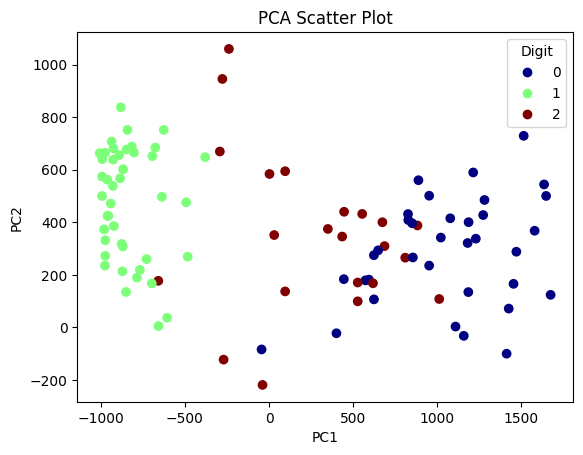

In [15]:
import matplotlib.pyplot as plt

scatter = plt.scatter(df_train['PC1'], df_train['PC2'], c=df_train['digit'], cmap="jet")
legend_elements = scatter.legend_elements()
labels = [str(digit) for digit in df_train['digit'].unique()]
plt.legend(handles=legend_elements[0], labels=labels, title='Digit')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatter Plot')
plt.show()

Now, lets take a point in the test set and plot it together with the training objects

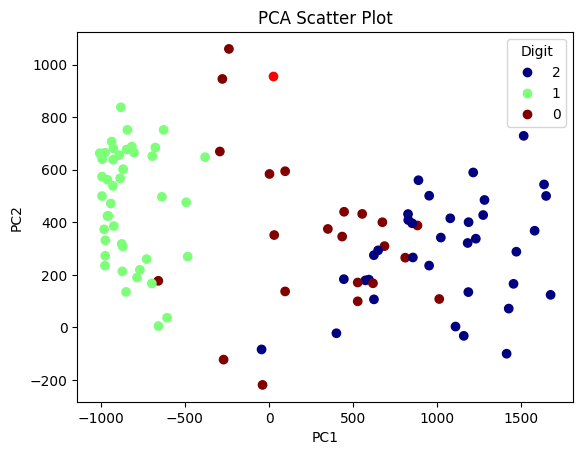

In [16]:
def plot_with_element(elements):
    scatter = plt.scatter(df_train['PC1'], df_train['PC2'], c=df_train['digit'], cmap="jet")
    legend_elements = scatter.legend_elements()
    labels = [str(digit) for digit in df_test['digit'].unique()]
    plt.legend(handles=legend_elements[0], labels=labels, title='Digit')

    for element in elements:
        plt.scatter(element.PC1, element.PC2, c='red')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA Scatter Plot')
    plt.show()

element = df_test.iloc[0]
plot_with_element([element])

To which class the red dot belongs?

One idea is to assign the object to the class of its closest object in the dataset

In [17]:
from scipy.spatial.distance import cdist

df_train_values = df_train[['PC1', 'PC2']].values

def get_nn(obj):
    point = np.array([[obj.PC1, obj.PC2]])
    distances = cdist(point, df_train_values, metric='euclidean')[0]
    idx_min = np.argmin(distances)
    return df_train.iloc[idx_min]

Now we can compare the digit of some object with the digit of its closest object

In [18]:
element = df_test.iloc[0]
print(element)
get_nn(element)

PC1       20.696962
PC2      955.584583
digit      2.000000
Name: 1, dtype: float64


PC1      -238.612737
PC2      1059.936584
digit       2.000000
Name: 31890, dtype: float64

So, the class of the closest object, the **nearest neighbor** is the same that the class of the object. Lets see another object:

In [19]:
element = df_test.iloc[1]
print(element)
get_nn(element)

PC1     -946.026868
PC2      430.843183
digit      1.000000
Name: 2, dtype: float64


PC1     -955.856274
PC2      424.372123
digit      1.000000
Name: 40884, dtype: float64

It is the same! So, it seems that the class of an object is probably the same the the class of its closest object. 

Lets test in how many object we get the same behavior:

In [20]:
count_total, count_correct = 0, 0
for idx in range(len(df_test)):
    element = df_test.iloc[idx]
    nn = get_nn(element)
    if nn.digit == element.digit:
        count_correct += 1
    count_total += 1
count_correct / count_total

0.811566571337782

Since more than 80% of the numbers has a nearest neighbor of its own class, we can use this property to create a classifier: **The nearest neighbor classifier**.

As we have seen there are objects where this property does not holds. Lets plot some of them.

In [21]:
wrong_elements = []
for idx in range(len(df_test)):
    element = df_test.iloc[idx]
    nn = get_nn(element)
    if nn.digit != element.digit:
        wrong_elements.append(element)

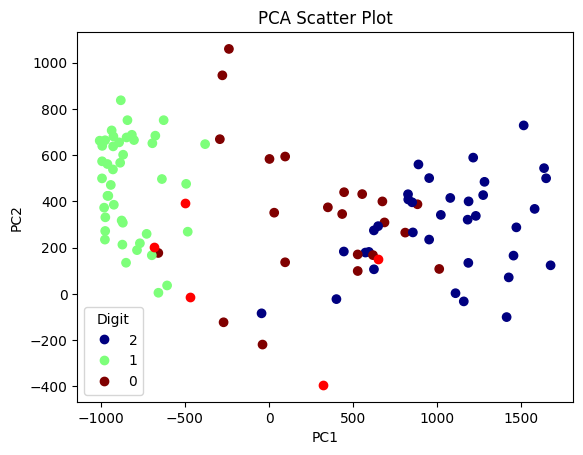

In [22]:
plot_with_element(wrong_elements[:5])

You can see here that the errors are mainly of two kind:
- objects in boundary locations between two classes
- objects close to outlayers

The nearest neigbor classifier is very sensitive to outliers. 
- Increase the numbers of neighbors to consider.

In [23]:
from sklearn.neighbors import NearestNeighbors

def get_k_nn(obj, k):
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(df_train_values)
    point = np.array([[obj.PC1, obj.PC2]])
    distances, indices = knn.kneighbors(point)
    nearest_points = df_train.iloc[indices[0]]
    return nearest_points

Lets take a look to other neighbors of the incorrectly classified objects we found before

In [24]:
print(wrong_elements[0])
get_k_nn(wrong_elements[0], 7)  

PC1     -499.948290
PC2      391.632772
digit      2.000000
Name: 43, dtype: float64


,PC1,PC2,digit
57714,-492.992267,476.127256,1
49499,-483.576142,269.206177,1
11943,-637.140822,497.030543,1
4865,-728.035400,259.749986,1
30596,-658.578812,177.146225,2
45532,-380.149823,648.025248,1
10136,-697.249532,167.157378,1


In [25]:
print(wrong_elements[2])
get_k_nn(wrong_elements[2], 7)  

PC1      646.58160
PC2      151.29841
digit      0.00000
Name: 55, dtype: float64


,PC1,PC2,digit
325,618.251765,167.834858,2
59605,624.086384,106.528622,0
42865,594.164926,181.635997,0
34051,573.391764,178.898010,0
54978,527.444200,170.711983,2
4047,623.679202,274.745504,0
56264,527.508029,99.115758,2


 If we consider more than one nearest neighbor, we can apply the **majority vote** to select the proper classification.
 
 Lets see what happen if we take the closest three neighbors.

In [26]:
k = 3

count_total, count_correct = 0, 0
for idx in range(len(df_test)):
    count_total += 1
    element = df_test.iloc[idx]
    nn = get_k_nn(element, k)
    vote = nn.digit.value_counts().index.tolist()[0]
    if vote == element.digit:
        count_correct += 1

count_correct / count_total

0.8252303781379091

So, it works a little better than with k=1. 

The nearest neighbors classifier considering more than one neighbor is called K Nearest Neighbor classifier, or KNN.

Lets now introduce the scikit-learn code to train the KNN classifier.

In [27]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(df_train[['PC1', 'PC2']], df_train.digit)

KNeighborsClassifier(n_neighbors=3)

Note:
- the KNN can be slower while classifying than other classifiers because of the huge amount of distances that need to be calculated for query object
- According to the used algorithm, some classifiers have slower training or testing times

In [28]:
from sklearn.metrics import accuracy_score
# Make predictions on the test set
y_pred = knn.predict(df_test[['PC1', 'PC2']])

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(df_test.digit, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8233238004448681


Lets explore the influence of k in the accuracy.

In [29]:
accuracies = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(df_train[['PC1', 'PC2']], df_train.digit)
    y_pred = knn.predict(df_test[['PC1', 'PC2']])
    accuracy = accuracy_score(df_test.digit, y_pred)
    accuracies.append((k, accuracy))

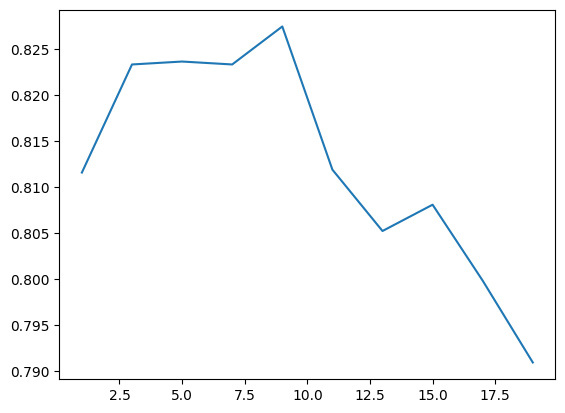

In [30]:
to_show = pd.DataFrame(accuracies, columns=['k', 'accuracy'])
plt.plot(to_show.k, to_show.accuracy)
plt.show()

Notes:
- The selection of the value of k have some influence in the quality of the result
- To select the best value for k you can use cross validation